# 1. Jet Data

In [1]:
from utils import Configs
from jetdata import JetDataclass

config = Configs("configs.yaml")
jets = JetDataclass(config=config)


INFO: created experiment instance GaussNoise_to_AspenOpenJets_MultiModalEPiC_2024.12.18_00h10_1121


/home/df630/Multimodal-Bridges/utils.py:511: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


### inspect data

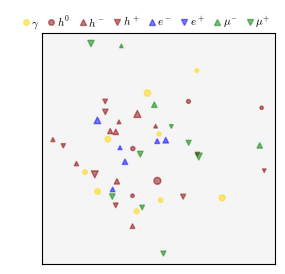

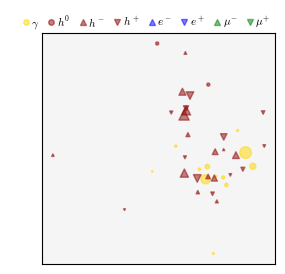

In [6]:
jets.source.display_cloud(idx=0, scale_marker=10.0)
jets.target.display_cloud(idx=3, scale_marker=2.0)

# 2. Absorbing Bridge Matching
Permutation equivariant architecture for point clouds

In [2]:
import torch
import lightning as L
from torch import nn
from dataclasses import dataclass

from architecture import MultiModalEPiC
from bridges import LinearUniformBridge, TelegraphBridge
from jetdata import BridgeState, OutputHeads


class AbsorbingBridgeMatching(L.LightningModule):
    """Model for hybrid data with varying size"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.vocab_size = config.data.vocab_size.features

        self.encoder = MultiModalEPiC(config)

        self.bridge_continuous = LinearUniformBridge(config)
        self.bridge_discrete = TelegraphBridge(config)
        self.bridge_absorbing = TelegraphBridge(config)

        self.loss_continuous_fn = nn.MSELoss(reduction="none")
        self.loss_discrete_fn = nn.CrossEntropyLoss(reduction="none")

        self.save_hyperparameters()

    def forward(self, state, batch):
        continuous, discrete, absorbing = self.encoder(
            t=state.time,
            x=state.continuous,
            k=state.discrete,
            mask=state.absorbing,
            context_continuous=getattr(batch, "context_continuous", None),
            context_discrete=getattr(batch, "context_discrete", None),
        )
        return OutputHeads(continuous, discrete, absorbing)

    def sample_bridges(self, batch):
        """sample stochastic bridges"""
        t = torch.rand(
            batch.target_continuous.shape[0], device=batch.target_continuous.device
        ).type_as(batch.target_continuous)

        time = self.reshape_time(t, batch.target_continuous)

        continuous = self.bridge_continuous.sample(
            time, batch.source_continuous, batch.target_continuous
        )

        discrete = self.bridge_discrete.sample(
            time, batch.source_discrete, batch.target_discrete
        )

        absorbing = self.bridge_absorbing.sample(
            time, batch.target_mask, batch.target_mask
        )
        return BridgeState(time, continuous, discrete, absorbing)

    def loss_continuous(self, heads: OutputHeads, state: BridgeState, batch):
        """mean square error loss for velocity field"""
        vector = heads.continuous
        mask = heads.absorbing

        ut = self.bridge_continuous.drift(
            t=state.time,
            x=state.continuous,
            x0=batch.source_continuous,
            x1=batch.target_continuous,
        ).to(vector.device)
        loss_mse = self.loss_continuous_fn(vector, ut) * mask
        return loss_mse.sum() / mask.sum()

    def loss_discrete(self, heads: OutputHeads, batch):
        """cross-entropy loss for discrete state classifier"""
        logits = heads.discrete
        targets = batch.target_discrete
        mask = heads.absorbing
        logits = heads.discrete.reshape(-1, self.vocab_size)
        targets = batch.target_discrete.reshape(-1).long()
        targets = targets.to(logits.device)
        mask = mask.reshape(-1)
        loss_ce = self.loss_discrete_fn(logits, targets) * mask
        return loss_ce.sum() / mask.sum()

    def reshape_time(self, t, x):
        if isinstance(t, (float, int)):
            return t
        else:
            return t.reshape(-1, *([1] * (x.dim() - 1)))

    ###########################
    ### Lightning functions ###
    ###########################

    def training_step(self, batch, batch_idx):
        state = self.sample_bridges(batch)
        state = state.to(self.device)
        heads = self.forward(state, batch)
        loss_continous = self.loss_continuous(heads, state, batch)
        loss_discrete = self.loss_discrete(heads, batch)
        loss = loss_continous + loss_discrete
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        state = self.sample_bridges(batch)
        state = state.to(self.device)
        heads = self.forward(state, batch)
        loss_continous = self.loss_continuous(heads, state, batch)
        loss_discrete = self.loss_discrete(heads, batch)
        loss = loss_continous + loss_discrete
        self.log("val_loss", loss, on_step=True, on_epoch=True)
        return loss

    def predict_step(self, batch, batch_idx):
        """generate target data from source data using trained dynamics"""
        time_steps = torch.linspace(
            0.0,
            1.0 - self.config.pipeline.time_eps,
            self.config.pipeline.num_timesteps,
            device=self.device,
        )
        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
        delta_t = delta_t.to(self.device)
        state = BridgeState(
            time_steps[0],
            batch.source_continuous,
            batch.source_discrete,
            batch.source_mask,
        )
        state = state.to(self.device)
        for time in time_steps[1:]:
            state.time = torch.full((len(batch[0]), 1), time.item(), device=self.device)
            heads = self.forward(state, batch)
            state = self.bridge_continuous.solver_step(state, heads, delta_t)
            state = self.bridge_discrete.solver_step(state, heads, delta_t)
        return state

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.config.train.optimizer.params.lr
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.config.train.scheduler.params.T_max,  # Adjust as needed
            eta_min=self.config.train.scheduler.params.eta_min,  # Adjust as needed
        )
        return [optimizer], [scheduler]


In [3]:
from utils import DataloaderModule

jets.preprocess()
dataloader = DataloaderModule(config=config, dataclass=jets)
databatch = next(dataloader.train.__iter__())
abm = AbsorbingBridgeMatching(config)


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.7/0.1/0.2
INFO: train size: 7000, validation size: 1000, testing sizes: 2000


/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [4]:
from lightning.pytorch import Trainer

model = Trainer(
    max_epochs=10,
    log_every_n_steps=5,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=1.0,
)

model.fit(abm, train_dataloaders=dataloader.train, val_dataloaders=dataloader.valid)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name               | Type             | Params | Mode 
----------------------------------------------------------------
0 | encoder            | MultiModalEPiC   | 826 K  | train
1 | loss_continuous_fn | MSELoss          | 0      | train
2 | loss_discrete_fn   | CrossEntropyLoss | 0      | train
----------------------------------------------------------------
826 K     Trainable params
0         Non-trainable params
826 K     Total params
3.305     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


# 3. Generate data:

In [ ]:
generation = model.predict(abm, dataloaders=dataloader.test)


In [6]:
from jetdata import ParticleClouds

sample = ParticleClouds(dataset=generation[0])
sample.postprocess()
sample.display_cloud(idx=0, scale_marker=10.0)

NameError: name 'generation' is not defined